Install Dependencies

In [34]:
!pip install fair-esm  # latest release, OR:
!pip install git+https://github.com/facebookresearch/esm.git  # bleeding edge, current repo main branch
    

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-tbgfc2zk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-tbgfc2zk
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import random
from collections import Counter
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import esm
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline

In [35]:
from Bio import SeqIO

def load_fasta_with_label(filename):
    data = []
    with open(filename, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            seq_name = record.id
            label = int(record.id.split("|")[-1].strip())  # Extract the label from the sequence name
            sequence = str(record.seq)
            data.append((seq_name, label, sequence))
    return data

train_fasta_file = "/kaggle/input/petase-and-non-petases-protein-sequences/train.fasta"
train_seq = load_fasta_with_label(train_fasta_file)

test_fasta_file = "/kaggle/input/petase-and-non-petases-protein-sequences/test.fasta"
test_seq = load_fasta_with_label(test_fasta_file)


## Train:
### {'negative-pet': 101, 'synthetic-pet': 84, 'real-pet': 82}
## Test: 
### {'real-pet': 22, 'negative-pet': 29, 'synthetic-pet': 16}
## All:
### {'negative-pet': 130, 'synthetic-pet': 100, 'real-pet': 104}

## Show Self Attention map

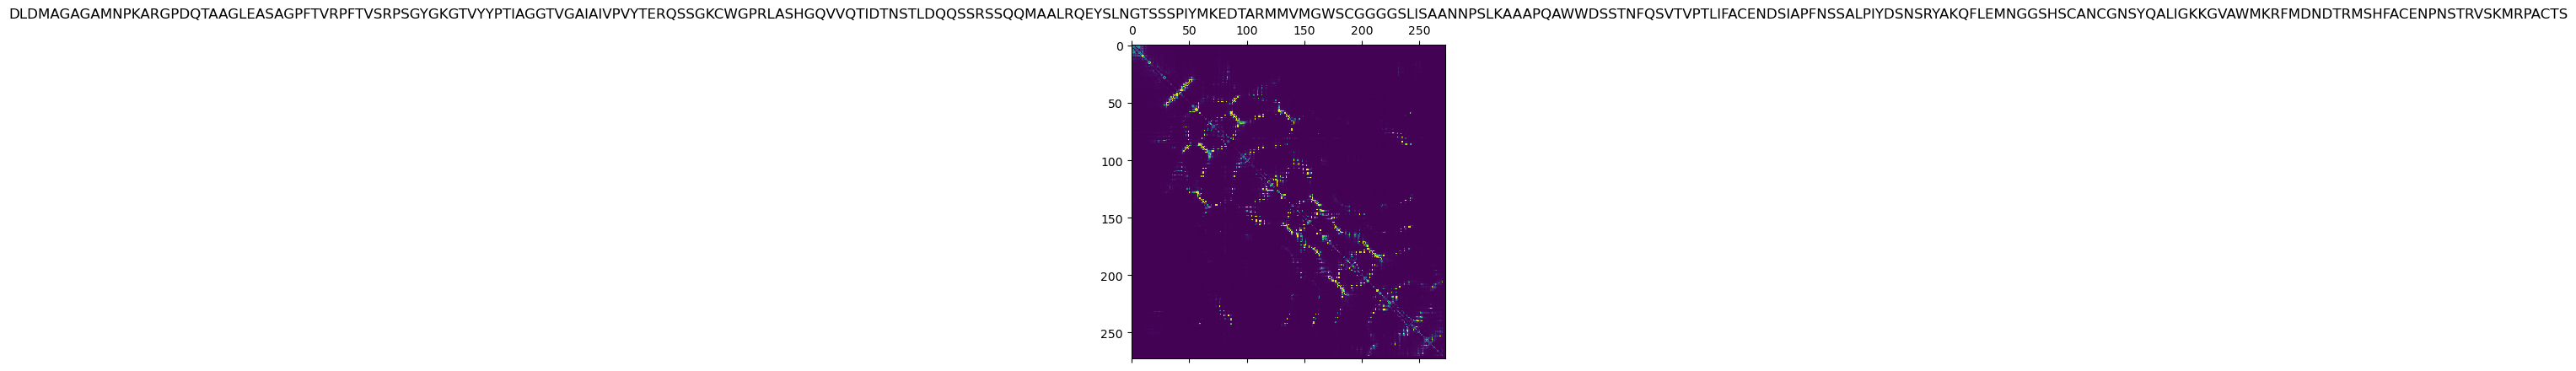

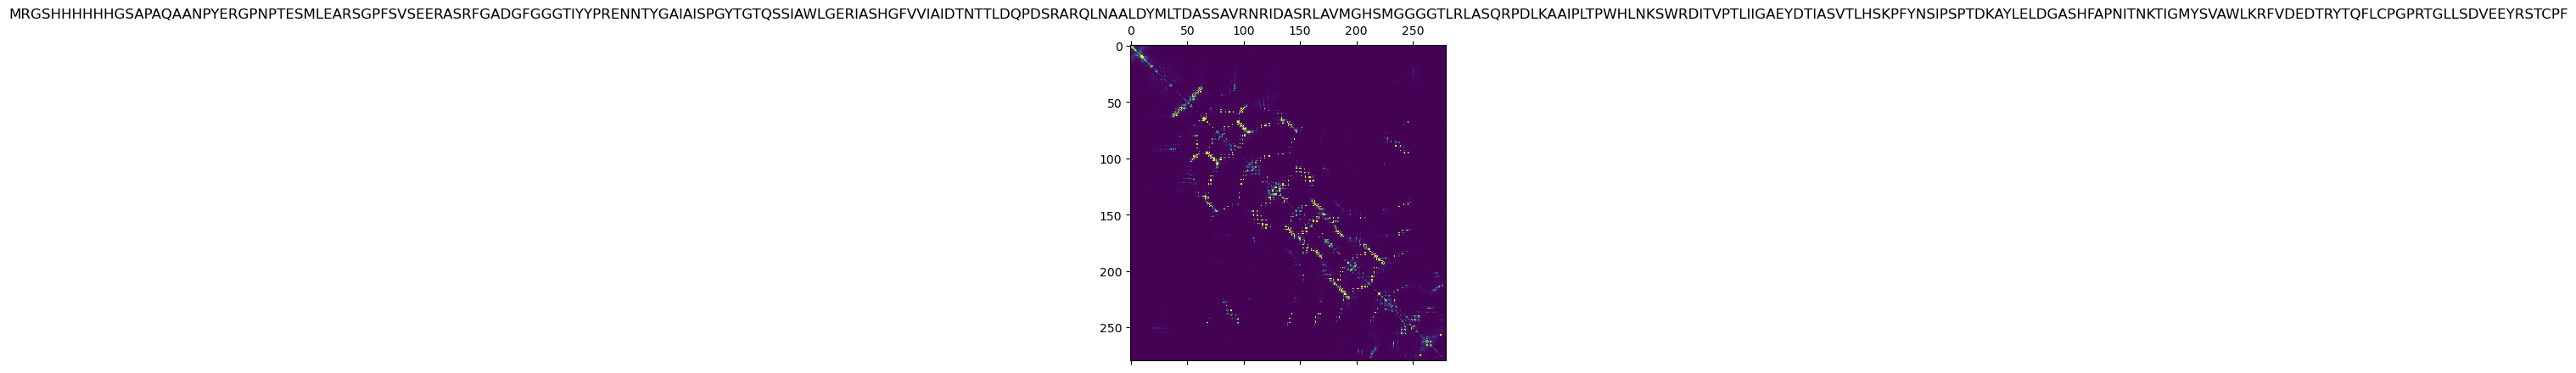

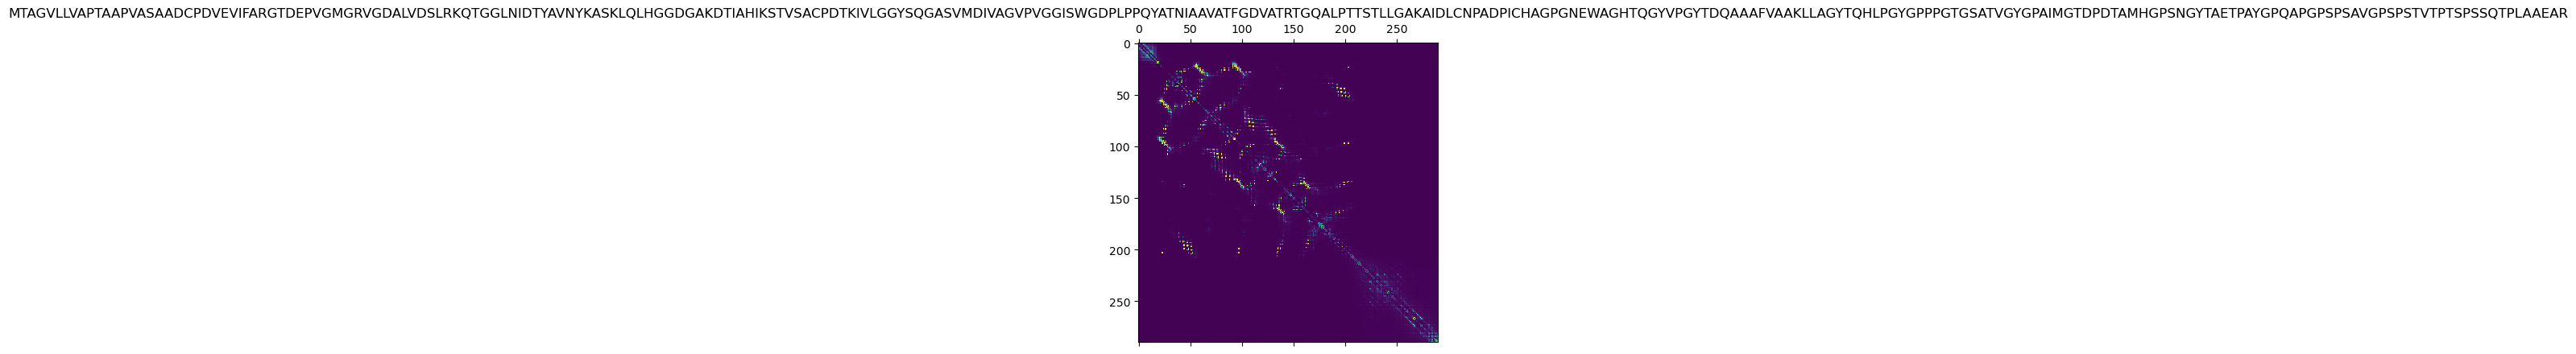

In [36]:

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("GAN Sample 1", "DLDMAGAGAMNPKARGPDQTAAGLEASAGPFTVRPFTVSRPSGYGKGTVYYPTIAGGTVGAIAIVPVYTERQSSGKCWGPRLASHGQVVQTIDTNSTLDQQSSRSSQQMAALRQEYSLNGTSSSPIYMKEDTARMMVMGWSCGGGGSLISAANNPSLKAAAPQAWWDSSTNFQSVTVPTLIFACENDSIAPFNSSALPIYDSNSRYAKQFLEMNGGSHSCANCGNSYQALIGKKGVAWMKRFMDNDTRMSHFACENPNSTRVSKMRPACTS"),
    ("PET Cutinase","MRGSHHHHHHGSAPAQAANPYERGPNPTESMLEARSGPFSVSEERASRFGADGFGGGTIYYPRENNTYGAIAISPGYTGTQSSIAWLGERIASHGFVVIAIDTNTTLDQPDSRARQLNAALDYMLTDASSAVRNRIDASRLAVMGHSMGGGGTLRLASQRPDLKAAIPLTPWHLNKSWRDITVPTLIIGAEYDTIASVTLHSKPFYNSIPSPTDKAYLELDGASHFAPNITNKTIGMYSVAWLKRFVDEDTRYTQFLCPGPRTGLLSDVEEYRSTCPF"),
    ("Non PET Cutinase", "MTAGVLLVAPTAAPVASAADCPDVEVIFARGTDEPVGMGRVGDALVDSLRKQTGGLNIDTYAVNYKASKLQLHGGDGAKDTIAHIKSTVSACPDTKIVLGGYSQGASVMDIVAGVPVGGISWGDPLPPQYATNIAAVATFGDVATRTGQALPTTSTLLGAKAIDLCNPADPICHAGPGNEWAGHTQGYVPGYTDQAAAFVAAKLLAGYTQHLPGYGPPPGTGSATVGYGPAIMGTDPDTAMHGPSNGYTAETPAYGPQAPGPSPSAVGPSPSTVTPTSPSSQTPLAAEAR")
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

# Creating sequence embeding for train dataset

In [37]:
!git clone https://github.com/facebookresearch/esm.git

fatal: destination path 'esm' already exists and is not an empty directory.


In [38]:
!python ./esm/scripts/extract.py esm2_t33_650M_UR50D {train_fasta_file} \
 /kaggle/working/train-emb --repr_layers 0 32 33 --include mean per_tok

Transferred model to GPU
Read /kaggle/input/petase-and-non-petases-protein-sequences/train.fasta with 267 sequences
Processing 1 of 21 batches (15 sequences)
Processing 2 of 21 batches (15 sequences)
Processing 3 of 21 batches (15 sequences)
Processing 4 of 21 batches (15 sequences)
Processing 5 of 21 batches (15 sequences)
Processing 6 of 21 batches (15 sequences)
Processing 7 of 21 batches (15 sequences)
Processing 8 of 21 batches (14 sequences)
Processing 9 of 21 batches (13 sequences)
Processing 10 of 21 batches (13 sequences)
Processing 11 of 21 batches (13 sequences)
Processing 12 of 21 batches (13 sequences)
Processing 13 of 21 batches (13 sequences)
Processing 14 of 21 batches (13 sequences)
Processing 15 of 21 batches (12 sequences)
Processing 16 of 21 batches (12 sequences)
Processing 17 of 21 batches (12 sequences)
Processing 18 of 21 batches (12 sequences)
Processing 19 of 21 batches (11 sequences)
Processing 20 of 21 batches (8 sequences)
Processing 21 of 21 batches (3 seq

In [39]:
!rm -r /kaggle/working/test-emb 

In [40]:
!python ./esm/scripts/extract.py esm2_t33_650M_UR50D {test_fasta_file} \
 /kaggle/working/test-emb --repr_layers 0 32 33 --include mean per_tok

Transferred model to GPU
Read /kaggle/input/petase-and-non-petases-protein-sequences/test.fasta with 67 sequences
Processing 1 of 6 batches (15 sequences)
Processing 2 of 6 batches (13 sequences)
Processing 3 of 6 batches (13 sequences)
Processing 4 of 6 batches (12 sequences)
Processing 5 of 6 batches (10 sequences)
Processing 6 of 6 batches (4 sequences)


In [43]:
TEST_FASTA_PATH = "/kaggle/input/petase-and-non-petases-protein-sequences/test.fasta" # Path to  fasta
TEST_EMB_PATH = "/kaggle/working/test-emb" # Path to directory of embeddings for  .fasta
TEST_EMB_LAYER = 33

In [44]:
FASTA_PATH = "/kaggle/input/petase-and-non-petases-protein-sequences/train.fasta" # Path to  fasta
EMB_PATH = "/kaggle/working/train-emb" # Path to directory of embeddings for  fasta
EMB_LAYER = 33

In [45]:
!ls /kaggle/working/test-emb

'negative-pet_07|0.pt'	 'negative-pet_61|0.pt'  'real-pet_84|1.pt'
'negative-pet_08|0.pt'	 'negative-pet_68|0.pt'  'real-pet_87|1.pt'
'negative-pet_100|0.pt'  'negative-pet_79|0.pt'  'real-pet_88|1.pt'
'negative-pet_101|0.pt'  'negative-pet_81|0.pt'  'real-pet_96|1.pt'
'negative-pet_105|0.pt'  'negative-pet_88|0.pt'  'real-pet_98|1.pt'
'negative-pet_106|0.pt'  'negative-pet_94|0.pt'  'synthetic-pet_07|1.pt'
'negative-pet_111|0.pt'  'real-pet_01|1.pt'	 'synthetic-pet_09|1.pt'
'negative-pet_112|0.pt'  'real-pet_17|1.pt'	 'synthetic-pet_19|1.pt'
'negative-pet_127|0.pt'  'real-pet_20|1.pt'	 'synthetic-pet_20|1.pt'
'negative-pet_128|0.pt'  'real-pet_21|1.pt'	 'synthetic-pet_31|1.pt'
'negative-pet_130|0.pt'  'real-pet_22|1.pt'	 'synthetic-pet_41|1.pt'
'negative-pet_15|0.pt'	 'real-pet_24|1.pt'	 'synthetic-pet_44|1.pt'
'negative-pet_18|0.pt'	 'real-pet_27|1.pt'	 'synthetic-pet_47|1.pt'
'negative-pet_23|0.pt'	 'real-pet_28|1.pt'	 'synthetic-pet_57|1.pt'
'negative-pet_34|0.pt'	 'real-pet_37|1.p

In [47]:
ys_train = []
Xs_train = []
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys_train.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs_train.append(embs['mean_representations'][EMB_LAYER])
Xs_train = torch.stack(Xs_train, dim=0).numpy()
print(len(ys_train))
print(Xs_train.shape)

267
(267, 1280)


In [48]:
ys_test = []
Xs_test = []
for header, _seq in esm.data.read_fasta(TEST_FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys_test.append(float(scaled_effect))
    fn = f'{TEST_EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs_test.append(embs['mean_representations'][TEST_EMB_LAYER])
Xs_test = torch.stack(Xs_test, dim=0).numpy()
print(len(ys_test))
print(Xs_test.shape)

67
(67, 1280)


## PCA 
Principal Component Analysis is a popular technique for dimensionality reduction. Given n_features (1280 in our case), PCA computes a new set of X that "best explain the data." We've found that this enables downstream models to be trained faster with minimal loss in performance.

Here, we set X to 60, but feel free to change it!

In [49]:
num_pca_components = 20
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

## Visualize Embeddings
Here, we plot the first two principal components on the x- and y- axes. Each point is then colored by its scaled effect (what we want to predict).

Visually, we can see a separation based on color/effect, suggesting that our representations are useful for this task, without any task-specific training!

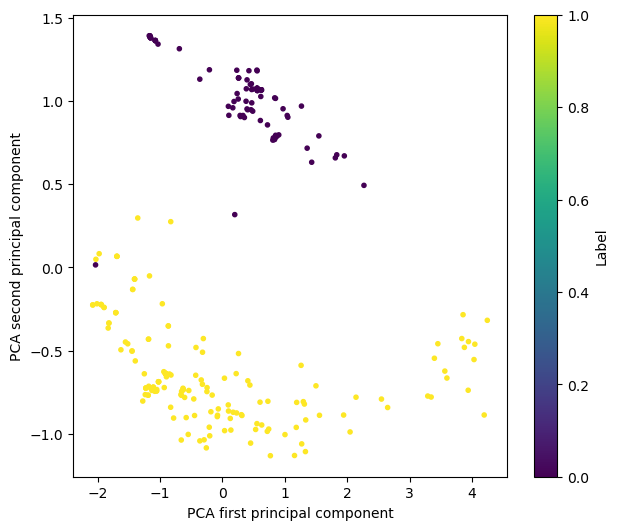

In [50]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Label')

Run Grid Search
(will take a few minutes on a single core)

In [64]:
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
# Assuming you have already defined Xs_train, ys_train, Xs_test, ys_test
# Xs_train, Xs_test: (267, 1280) - Features
# ys_train, ys_test: (267, 1) - Target labels

# Create pipelines for each model
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])
knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

# Hyperparameter grid for SVM
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
}

# Hyperparameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
}

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
}

# Grid search with cross-validation for SVM
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, n_jobs=-1)
svm_grid_search.fit(Xs_train, ys_train)

# Grid search with cross-validation for KNN
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, n_jobs=-1)
knn_grid_search.fit(Xs_train, ys_train)

# Grid search with cross-validation for Random Forest
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, n_jobs=-1)
rf_grid_search.fit(Xs_train, ys_train)

# Get the best models from grid search
best_svm_model = svm_grid_search.best_estimator_
best_knn_model = knn_grid_search.best_estimator_
best_rf_model = rf_grid_search.best_estimator_



SVM Accuracy: 0.9000
KNN Accuracy: 0.9000
Random Forest Accuracy: 0.9000


In [65]:

# Predict using the best models
Xs_test = Xs_test[:10]
ys_test = ys_test[:10]
svm_preds = best_svm_model.predict(Xs_test)
knn_preds = best_knn_model.predict(Xs_test)
rf_preds = best_rf_model.predict(Xs_test)

# Calculate accuracies
svm_accuracy = accuracy_score(ys_test, svm_preds)
knn_accuracy = accuracy_score(ys_test, knn_preds)
rf_accuracy = accuracy_score(ys_test, rf_preds)

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

SVM Accuracy: 0.9000
KNN Accuracy: 0.9000
Random Forest Accuracy: 0.9000
